# Univariate HP with Exponential Delay

In this notebook, we present an example use case of fitting (calibrating) and sampling from a univariate Hawkes (self-exciting) process with exponential delay density. Concretely, the HP is determined by the conditional intensity function

$$
\begin{align}
\lambda^*(t) &= \mu + \alpha \sum_{t_j < t} g_\theta(t - t_j) \\
g_\theta(x) &= -\theta \exp (-\theta x )
\end{align}
$$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from hawkeslib.model.uv_exp import UnivariateExpHawkesProcess as UVHP

## Example 1: FX Price Jump Data

Fit to real data and get Monte Carlo estimates of the distribution of number of occurrences via Ogata's modified thinning method.

In [3]:
df = pd.read_csv("example_data.csv", header=None)
df.columns = ["mark", "time"]

In [4]:
# take all mark 21 and fit a univariate exp HP
td = np.array(df.loc[df.mark == 21, :].get("time")).astype(np.float64)

proc = UVHP()
proc.fit(td, method="em")

-58574.97098100516

In [5]:
# verify that the unconditional mean makes sense
mu, alpha, theta = proc.get_params()

N_approx = mu * td[-1] / (1 - alpha)

print(N_approx)
print(len(td))

8005.669015748907
8003


In [6]:
%%time
# take unconditioned samples from this HP, and estimate the distribution of 
# number of occurrences in a ten second period

counts = []
for j in range(100000):
    n = len(proc.sample(T=10000))  # time in millis
    counts.append(n)

CPU times: user 5.65 s, sys: 100 ms, total: 5.75 s
Wall time: 1.52 s


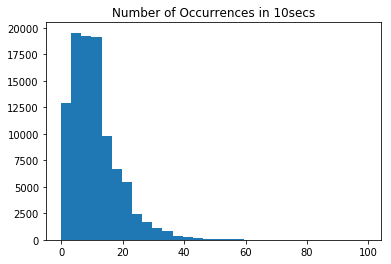

In [7]:
plt.title("Number of Occurrences in 10secs")
plt.hist(counts, bins=30)
plt.show()

## Example 2: Simulated Data

We simulate HPs and try to fit their parameters.

In [8]:
param_pairs = []
for j in range(100):
    # priors
    pars = np.random.gamma(3.), np.random.rand() * .3, 1/np.random.gamma(1.)

    hp = UVHP()
    hp.set_params(*pars)
    smp = hp.sample(10000, method="branching")
    
    # fit with gd
    hp2 = UVHP()
    hp2.fit(smp, method="gd")
    
    # fit with em
    hp3 = UVHP()
    hp3.fit(smp, method="em", reltol=1e-8)
    
    comb_pars = hp.get_params() + hp2.get_params() + hp3.get_params()
    param_pairs.append(comb_pars)

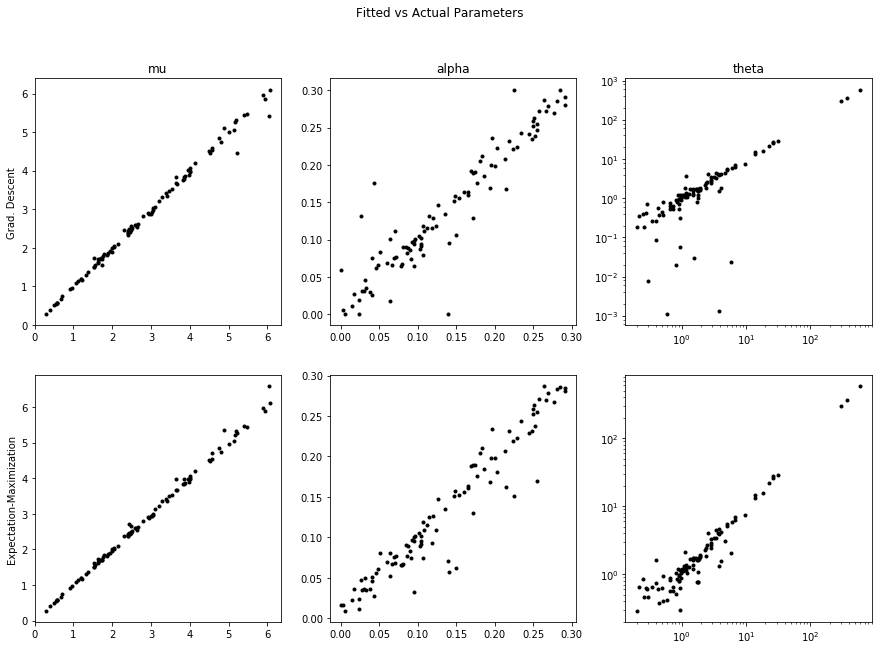

In [9]:
Z = np.array(param_pairs)

f, ax = plt.subplots(2, 3, figsize=(15,10))
f.suptitle("Fitted vs Actual Parameters")
for k in range(3):
    ax[0][k].plot(Z[:, k], Z[:, k+3], "k.")
    ax[0][k].set_title(["mu", "alpha", "theta"][k])
    
    ax[1][k].plot(Z[:, k], Z[:, k+6], "k.")

ax[0,2].loglog()
ax[1,2].loglog()

ax[0,0].set_ylabel("Grad. Descent")
ax[1,0].set_ylabel("Expectation-Maximization")
